In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy import stats, integrate
from scipy.stats import ttest_ind
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

In [74]:
###### CAP Ratios and fold change
###### H_1104/H_1105, H_1104/H_1105 2FC, C_0113/C_0114, C_0113/C_0114 2FC
###### [(H_1104+H_1105)/(C_0113/C_0114)], [(H_1104+H_1105)/(C_0113/C_0114)] 2FC

sample_info = pd.read_csv('HD_mRNASeq_sample_info.csv', sep=',', comment='#')

# Pull dataset ids, pull cap ids, pull control cap ids, pull hd cap ids respectively
dataset_ids = sample_info['Dataset.dataset_id'].tolist()
cap = [ _ for _ in dataset_ids if "CAP" in _]
ccap = [ _ for _ in cap if _.startswith('C')]
hcap = [ _ for _ in cap if _.startswith('H')]

df1 = pd.read_csv("all_salmon_norm.csv")

col = list(df1)
col = col[:1] + cap
df_cap = df1[col]
df_cap = df_cap[(df_cap != 0).all(1)]
#df_cap.to_csv("all_CAP2_norm.csv", index=False)

# df_cap copy for use
df_cap1 = df_cap[(df_cap != 0).all(1)]
#df_cap.to_csv("all_CAP_norm.csv", index=False)

# H_1104/H_1105 ratio and log2 FC of ratio, C_0113/C_0114 ratio and log2 FC of ratio
df_cap1['H_CAP'] = df_cap1['H_1104_CAP_mRNASeq']/df_cap1['H_1105_CAP_mRNASeq']
df_cap1['C_CAP'] = df_cap1['C_0113_CAP_mRNASeq']/df_cap1['C_0114_CAP_mRNASeq']
df_cap1['H_CAP_L2FC'] = np.log2(df_cap1['H_CAP'])
df_cap1['C_CAP_L2FC'] = np.log2(df_cap1['C_CAP'])

# H/C ratio and log2 FC of ratop
df_cap1['H/C'] = (df_cap1['H_1104_CAP_mRNASeq']+ df_cap1['H_1105_CAP_mRNASeq'])/(df_cap1['C_0113_CAP_mRNASeq']+ df_cap1['C_0114_CAP_mRNASeq'])

# all_L2FC = LOG2(H1104+H1105/C113+C114), named as all since H/C_L2FC confuses python -> can't pull column into plot
df_cap1['all_L2FC'] = np.log2(df_cap1['H/C'])
# Drop cap counts
df_cap1.drop([col for col in df_cap1.columns if 'mRNASeq' in col],axis=1,inplace=True)

# Remove inf, -inf, NA, and 0 from df
df_cap1 = df_cap1.replace([np.inf, -np.inf], np.nan)
df_cap1 = df_cap1.dropna()
df_cap1 = df_cap1[(df_cap1 != 0).all(1)]
#df_cap1.to_csv("all_CAP2_norm.csv", index=False)

/Users/Mojito/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/Mojito/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


gene_id       ENSG00000000003.14
H_CAP                 9.6709e-10
C_CAP                7.09735e-10
H_CAP_L2FC              -29.9456
C_CAP_L2FC               -30.392
H/C                    0.0340189
all_L2FC                -4.87752
Entropy                  0.29313
dtype: object
gene_id       ENSG00000283696.1
H_CAP               4.46524e+06
C_CAP               1.49284e+09
H_CAP_L2FC              22.0903
C_CAP_L2FC              30.4754
H/C                     58.8423
all_L2FC                5.87878
Entropy                       2
dtype: object


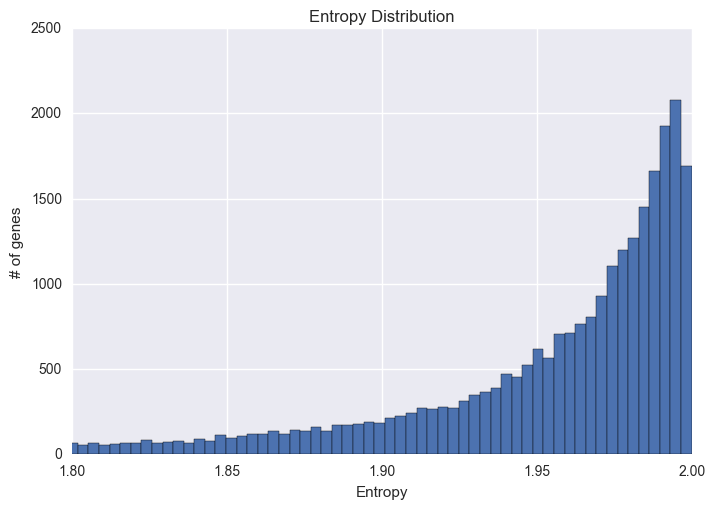

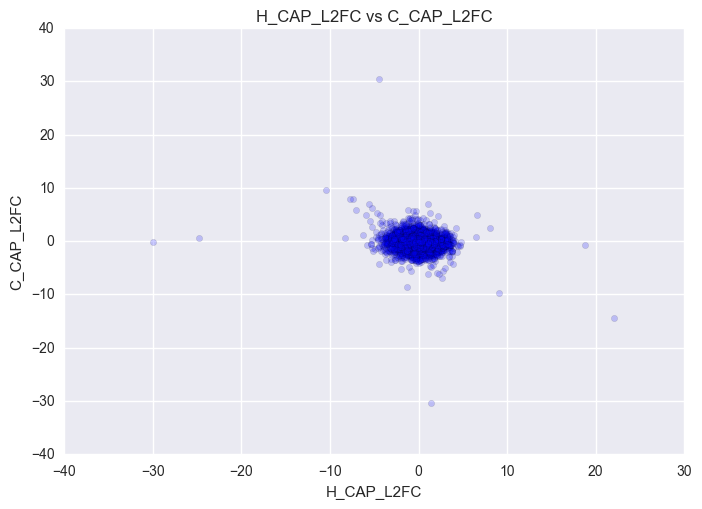

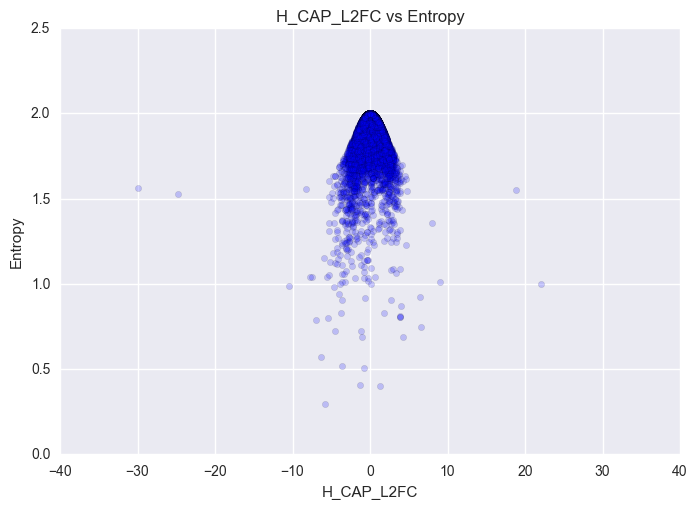

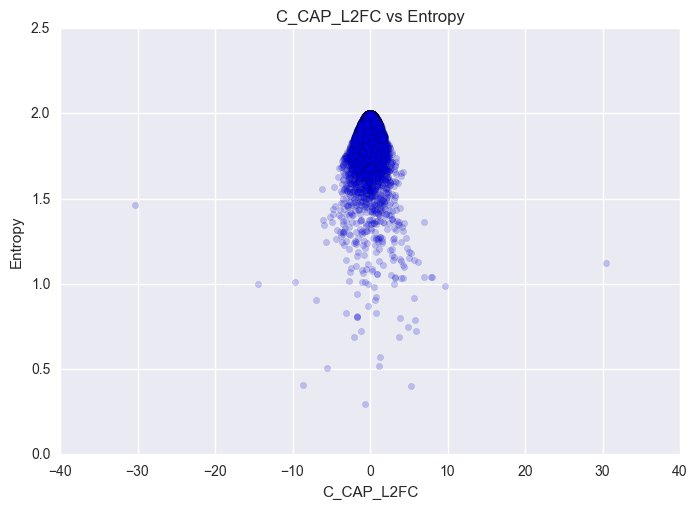

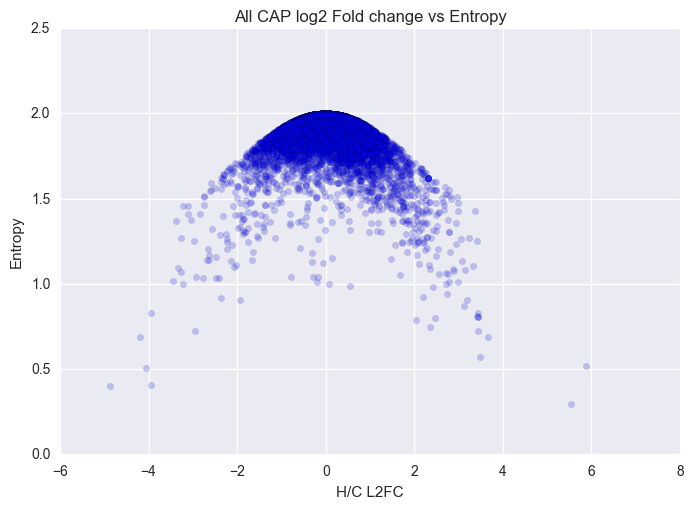

In [75]:
###### Entropy values
### p_i = sample/sum of all sample counts
### sum of all p_i = 1
### H = - sum of (p_i log p_i)

# Sum of gene counts
col = list(df1)
col = col[:1] + cap

# All CAP samples from all_salmon_norm.csv/ ALL GENE ROW SUM (probability), 27881 rows
df3 = df1[col]
df3.loc[:,'H_1105_CAP_mRNASeq':'C_0114_CAP_mRNASeq'] = df3.loc[:,'H_1105_CAP_mRNASeq':'C_0114_CAP_mRNASeq'].div(df3.sum(axis=1), axis=0)
assert((df3.sum(axis=1))==1).all

# Calculating entropy, 27243 rows after na dropped
df4 = df3
df4.loc[:,'H_1105_CAP_mRNASeq':'C_0114_CAP_mRNASeq']= -df3[cap] * np.log2(df3[cap])
df4["Entropy"] = df4.sum(axis=1)
df4 = df4.dropna()

# Drop all other columns than entropy
fix = list(df4)
fix = fix[:1] + fix[-1:]
ent = df4[fix]

# make new df using merge on gene_id
df_a = pd.merge(df_cap1, ent, on='gene_id')
df_a = df_a.dropna()

#ent.to_csv("CAP_entropy.csv", index=False)
print(df_a.min())
print(df_a.max())

# entropy
plt.hist(df_a["Entropy"], bins=500)
plt.axis([1.8,2,0,2500])
plt.title("Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("# of genes")
plt.show()

print()
# plot H1104/H1105 L2FC with C113/C114 L2FC
plt.scatter(df_a['H_CAP_L2FC'], df_a["C_CAP_L2FC"], alpha=0.2)
plt.title("H_CAP_L2FC vs C_CAP_L2FC")
plt.xlabel("H_CAP_L2FC")
plt.ylabel("C_CAP_L2FC")
plt.show()

print()
# plot H_CAP FC against entropy as scatter
plt.scatter(df_a['H_CAP_L2FC'], df_a["Entropy"], alpha=0.2)
plt.title("H_CAP_L2FC vs Entropy")
plt.xlim(-40, 40)
plt.xlabel("H_CAP_L2FC")
plt.ylabel("Entropy")
plt.show()

print()
# plot C_CAP FC against entropy as scatter
plt.scatter(df_a['C_CAP_L2FC'], df_a["Entropy"], alpha=0.2)
plt.title("C_CAP_L2FC vs Entropy")
plt.xlabel("C_CAP_L2FC")
plt.ylabel("Entropy")
plt.show()

print()
# plot FC against entropy as scatter
plt.scatter(df_a['all_L2FC'], df_a["Entropy"], alpha=0.2)
plt.title("All CAP log2 Fold change vs Entropy")
plt.xlabel("H/C L2FC")
plt.ylabel("Entropy")
plt.show()


/Users/Mojito/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


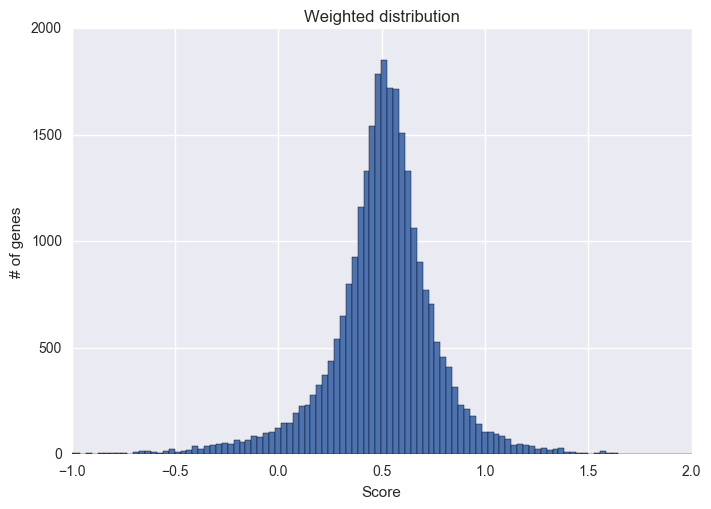

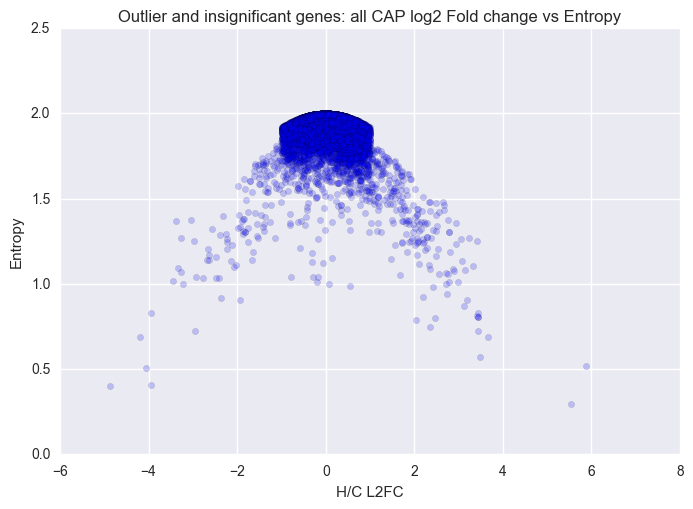

In [76]:
###### Manipulating df_a ###2 based on above scatter plots

# Pulling FC and Entropy values only, new 27243
column = list(df_a)
column = column[:1] + column[3:5] + column[6:]
new = df_a[column]
x = df_a[column]
x = x[column[1:]] * 0.25
new['Weighted'] = x.sum(axis=1)

# All Weighted distribution
plt.hist(new["Weighted"], bins=500)
plt.axis([-1,2,0,2000])
plt.title("Weighted distribution")
plt.xlabel("Score")
plt.ylabel("# of genes")
plt.show()

###### Outliers 
### oc = outlier counts on left, FC on right
### Outliers based on H_L2FC AND C_L2FC, 1068 rows
outliers = new[((new.H_CAP_L2FC > 1)|(new.H_CAP_L2FC < -1)) & ((new.C_CAP_L2FC < -1)|(new.C_CAP_L2FC > 1))]
o = list(outliers)
o = o[:1]
oc = outliers[o]
#print(len(oc.index))

## Check, 118+247+401+302=1068
# 118
u1 = new[(new.H_CAP_L2FC > 1) & (new.C_CAP_L2FC > 1)]
#print(len(u1.index))
# 247
u2 = new[(new.H_CAP_L2FC < -1) & (new.C_CAP_L2FC < -1)]
#print(len(u2.index))
# 401
u3 = new[(new.H_CAP_L2FC > 1) & (new.C_CAP_L2FC < -1)]
#print(len(u3.index))
# 302
u4 = new[(new.H_CAP_L2FC < -1) & (new.C_CAP_L2FC > 1)]
#print(len(u4.index))

### NOT SIGNIFICANT, want only genes which are doubled or halved, 25740 genes
outlier = new[(new.all_L2FC > -1) & (new.all_L2FC < 1)]
o1 = list(outlier)
o1 = o1[:1]
oc1 = outlier[o1]
#print(len(oc1.index))

# Outlier, entropy < 1.5, 285 rows
outlier2 = new[(new.Entropy < 1.5)]
o2 = list(outlier2)
o2 = o2[:1]
oc2 = outlier2[o2]
oc2 = pd.merge(pd.merge(oc2,df_cap,on='gene_id'),new,on='gene_id')
#print(len(oc2.index))
#oc2.to_csv("CAP_outlier1.5.csv", index=False)

#### OUTLIER ANALYSIS using entropy < 1.5 as it will give me maximum outliers from entropy
# Row from excel, gene name
# 18 ENSG00000277117.4
# 40 ENSG00000205358.3
# 79 ENSG00000124935.3
# 155 ENSG00000237436.1
# 211 ENSG00000269138.1
# 225 ENSG00000236627.1
pull = [16,38,77,153,209,223]
a = oc2.ix[pull]
# Analysis from a shows that I should use entropy < 1.4 for outliers, therefore entropy > 1.4 for usable data

# Outlier entropy < 1.4, 176 rows
outlier3 = new[(new.Entropy < 1.4)]
o3 = list(outlier3)
o3 = o3[:1]
oc3 = outlier3[o3]
#print(len(oc3.index))

# Merge both outliers into 1, drop duplicates if any, found 26,094 rows total
oc_t = pd.concat([oc,oc1,oc3])
oc_t = oc_t.drop_duplicates()
oc_t = pd.merge(pd.merge(oc_t,df_cap,on='gene_id'),new,on='gene_id')
#print(len(oc_t.index))

# plot FC against entropy as scatter
plt.scatter(oc_t['all_L2FC'], oc_t["Entropy"], alpha=0.2)
plt.title("Outlier and insignificant genes: all CAP log2 Fold change vs Entropy")
plt.axis([-6,8,0,2.5])
plt.xlabel("H/C L2FC")
plt.ylabel("Entropy")
plt.show()



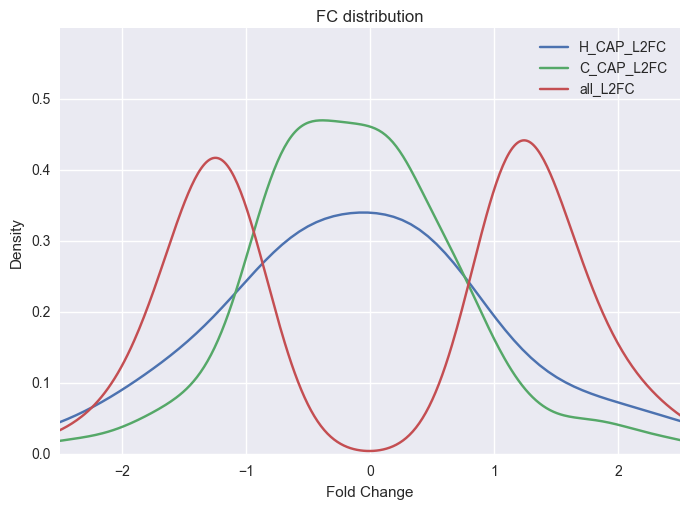

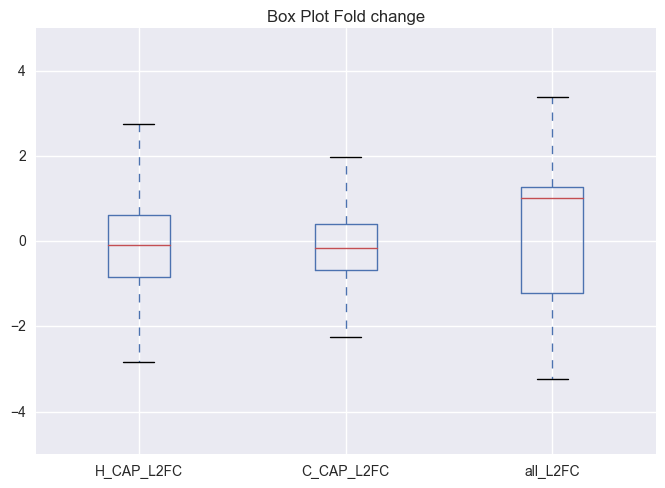

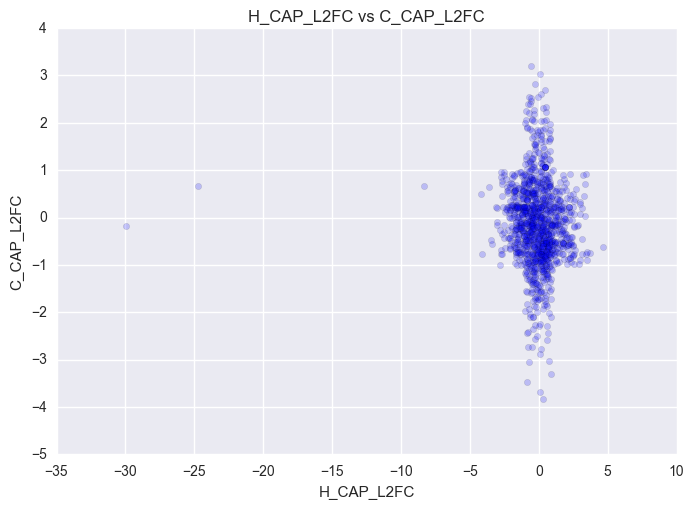

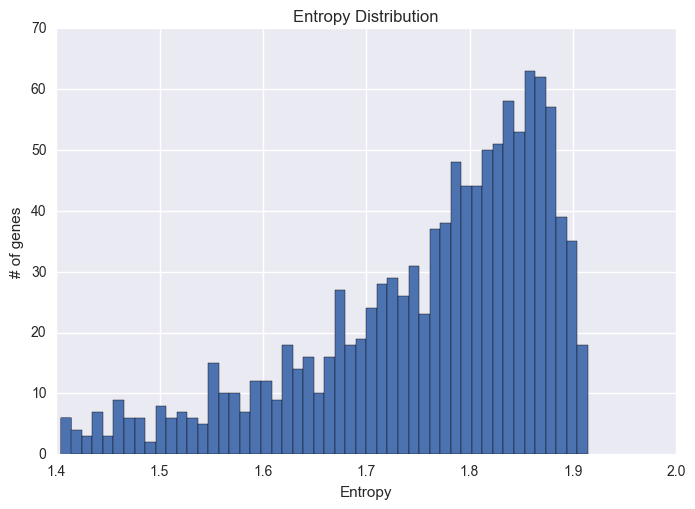

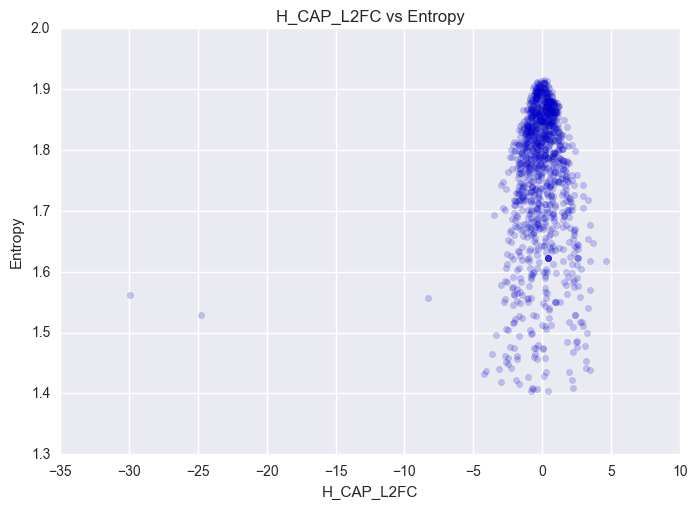

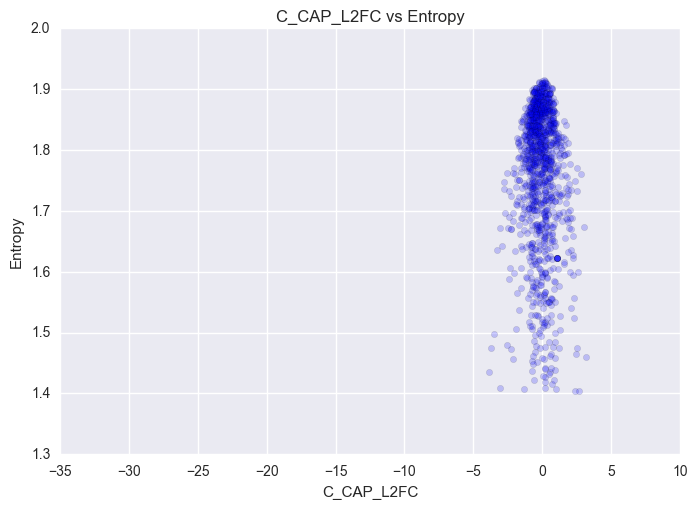

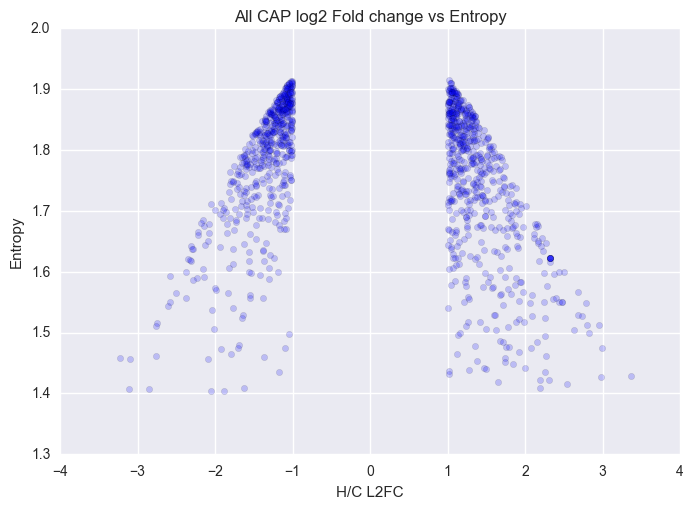

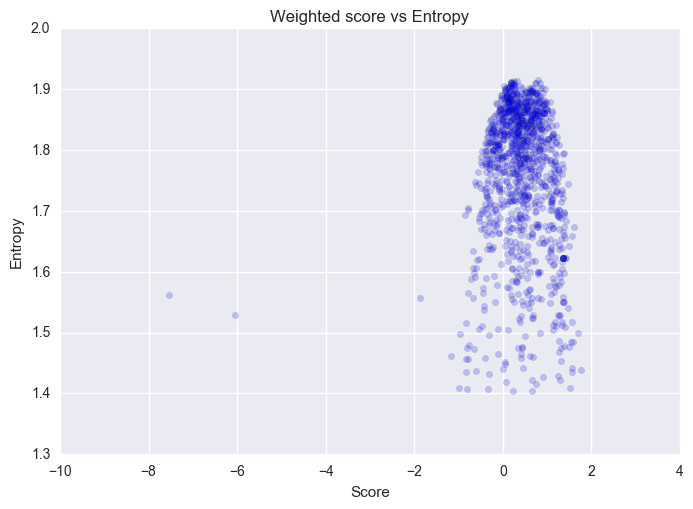

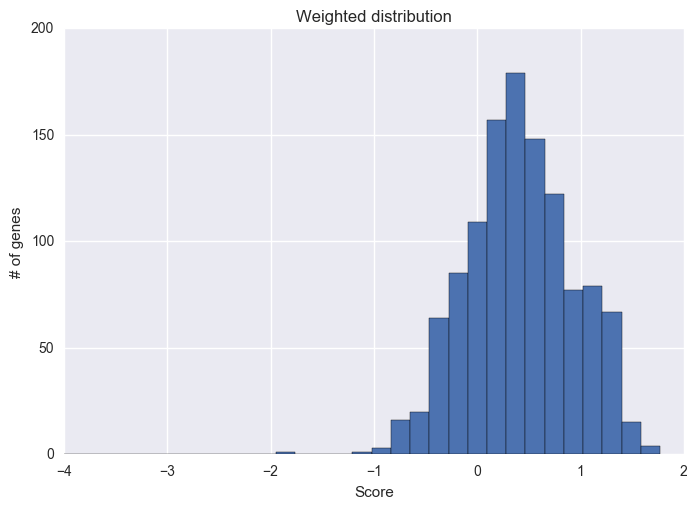

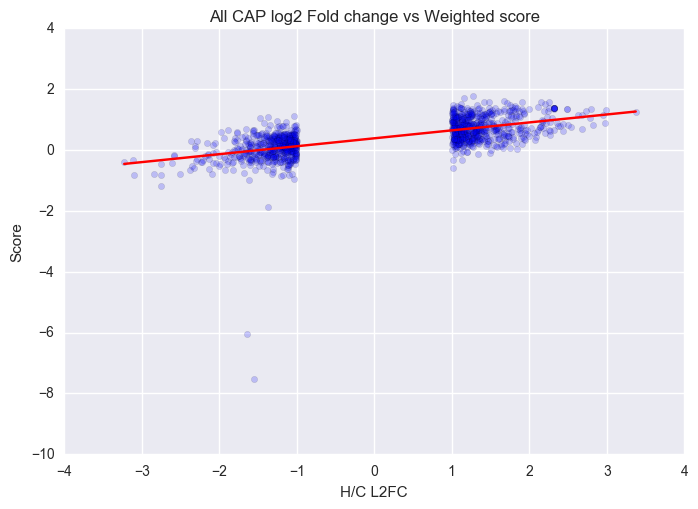

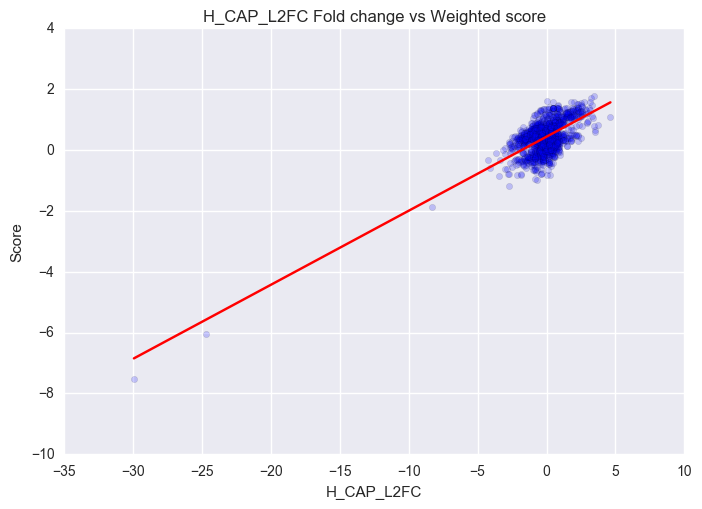

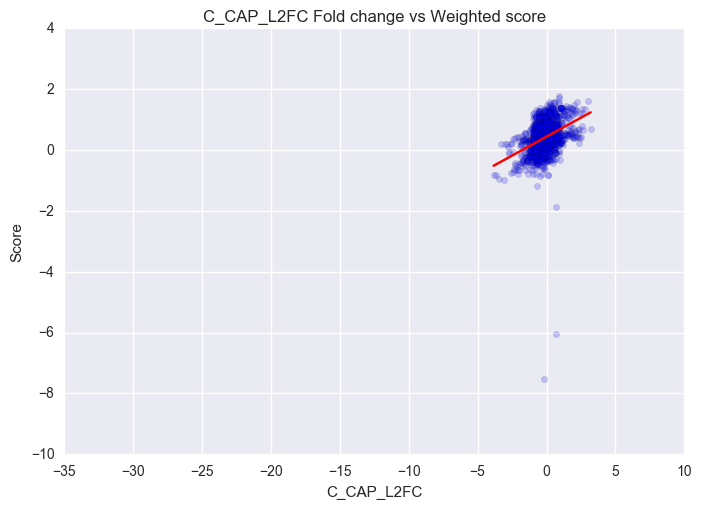

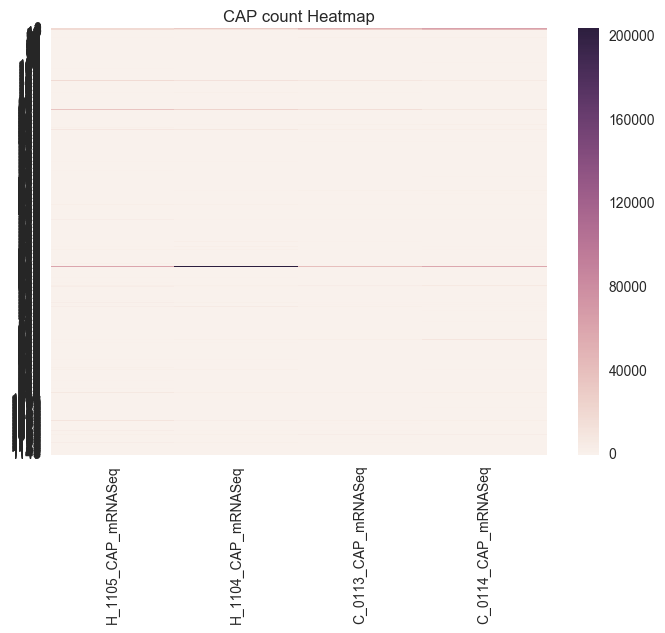

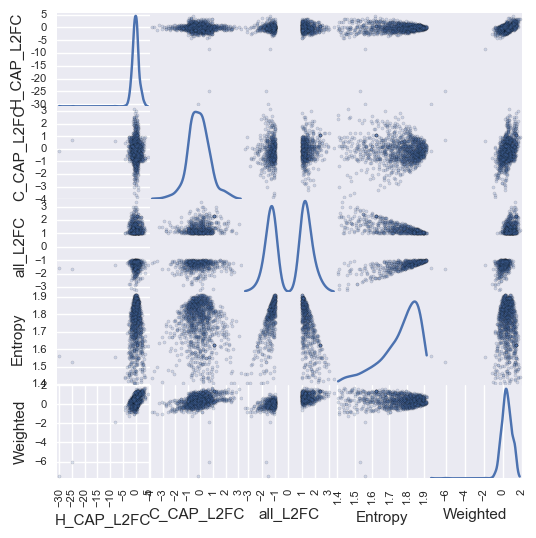

In [77]:
######  USABLE DATA, NOT OUTLIERS
### WEIGHTED = sum of  0.25*all columns

# outliers + insignificant gene names into a list
out = oc_t['gene_id'].values.tolist()

# use = 27243-26094 = 1149 rows, pulls gene names not in out list
use = new[~new['gene_id'].isin(out)]
u1 = list(use)
u1 = u1[:1]
uc1 = use[u1]
# uc2 = copy of uc1
uc2 = pd.merge(pd.merge(uc1,df_cap,on='gene_id'),new,on='gene_id')
uc1 = pd.merge(pd.merge(uc1,df_cap,on='gene_id'),new,on='gene_id')
#uc1.to_csv("use2b_CAP_norm.csv", index=False)

# uc2, copy of uc1 with HGNC gene names, 1142 rows due to dropping duplicates (genes with par_y)
uc2['gene_id'] = uc2['gene_id'].str.split('.').str[0]
en = pd.read_csv("mart_export.txt", sep="\t")
en = en.rename(columns = {'Gene stable ID':'gene_id'})
uc2 = pd.merge(en, uc2, on='gene_id')
uc2.drop_duplicates()
#uc2.to_csv("use2a_CAP_norm.csv", index=False)
#uc2['HGNC symbol'].to_csv("use2a_genes.csv", index=False)

# FC Distribution
c1 = ['H_CAP_L2FC','C_CAP_L2FC','all_L2FC']
c2 = uc1[c1]
c2.plot.kde()
plt.axis([-2.5,2.5,0,0.6])
plt.title("FC distribution")
plt.xlabel("Fold Change")
plt.show()

# FC Box plot
c2.plot.box()
plt.title("Box Plot Fold change")
plt.ylim(-5, 5)
plt.show()

print()
# plot H1104/H1105 L2FC with C113/C114 L2FC
plt.scatter(uc1['H_CAP_L2FC'], uc1["C_CAP_L2FC"], alpha=0.2)
plt.title("H_CAP_L2FC vs C_CAP_L2FC")
plt.xlabel("H_CAP_L2FC")
plt.ylabel("C_CAP_L2FC")
plt.show()

print()
# entropy
plt.hist(uc1['Entropy'], bins=50)
#plt.axis([1.8,2,0,800])
plt.title("Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("# of genes")
plt.show()

print()
# plot H_CAP FC against entropy as scatter
plt.scatter(uc1['H_CAP_L2FC'], uc1['Entropy'], alpha=0.2)
plt.title("H_CAP_L2FC vs Entropy")
plt.xlabel("H_CAP_L2FC")
plt.ylabel("Entropy")
plt.show()

print()
# plot C_CAP FC against entropy as scatter
plt.scatter(uc1['C_CAP_L2FC'], uc1['Entropy'], alpha=0.2)
plt.title("C_CAP_L2FC vs Entropy")
plt.xlim(-35, 10)
plt.xlabel("C_CAP_L2FC")
plt.ylabel("Entropy")
plt.show()

print()
# plot all FC against entropy as scatter
plt.scatter(uc1['all_L2FC'], uc1['Entropy'], alpha=0.2)
plt.title("All CAP log2 Fold change vs Entropy")
plt.xlabel("H/C L2FC")
plt.ylabel("Entropy")
plt.show()

print()
# plot weighted vs entropy
plt.scatter(uc1['Weighted'], uc1['Entropy'], alpha=0.2)
plt.title("Weighted score vs Entropy")
plt.xlabel("Score")
plt.ylabel("Entropy")
plt.show()

print()
# Weighted distribution
plt.hist(uc1['Weighted'], bins=50)
plt.axis([-4,2,0,200])
plt.title("Weighted distribution")
plt.xlabel("Score")
plt.ylabel("# of genes")
plt.show()

print()
# plot all FC against score as scatter
x = uc1['all_L2FC']
y = uc1['Weighted']
plt.scatter(uc1['all_L2FC'], uc1['Weighted'], alpha=0.2)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='r')
plt.title("All CAP log2 Fold change vs Weighted score")
plt.xlabel("H/C L2FC")
plt.ylabel("Score")
plt.show()

print()
# plot H_FC against score as scatter
x = uc1['H_CAP_L2FC']
y = uc1['Weighted']
plt.scatter(uc1['H_CAP_L2FC'], uc1['Weighted'], alpha=0.2)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='r')
plt.title("H_CAP_L2FC Fold change vs Weighted score")
plt.xlabel("H_CAP_L2FC")
plt.ylabel("Score")
plt.show()

print()
# plot C_FC against score as scatter
x = uc1['C_CAP_L2FC']
y = uc1['Weighted']
plt.scatter(uc1['C_CAP_L2FC'], uc1['Weighted'], alpha=0.2)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='r')
plt.title("C_CAP_L2FC Fold change vs Weighted score")
plt.xlim(-35, 10)
plt.xlabel("C_CAP_L2FC")
plt.ylabel("Score")
plt.show()

print()
col = list(uc1)
col = col[1:5]
heat = uc1[col]
#row_labels = uc1['gene_id'].values.tolist()
#column_labels = col
sns.heatmap(heat)
plt.title("CAP count Heatmap")
plt.show()

print()
uc1.drop([col for col in uc1.columns if 'mRNASeq' in col],axis=1,inplace=True)
scatter_matrix(uc1, alpha=0.2, figsize=(6, 6), diagonal='kde')
plt.show()

HD_CAP = uc2.loc[:,'H_1105_CAP_mRNASeq':'H_1104_CAP_mRNASeq']
cont_CAP = uc2.loc[:,'C_0113_CAP_mRNASeq':'C_0114_CAP_mRNASeq']
test = stats.ttest_ind(a= HD_CAP, b= cont_CAP,equal_var=False)

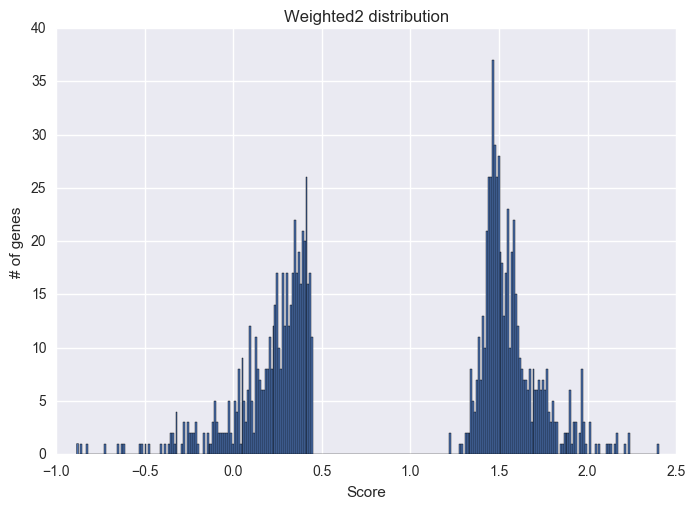

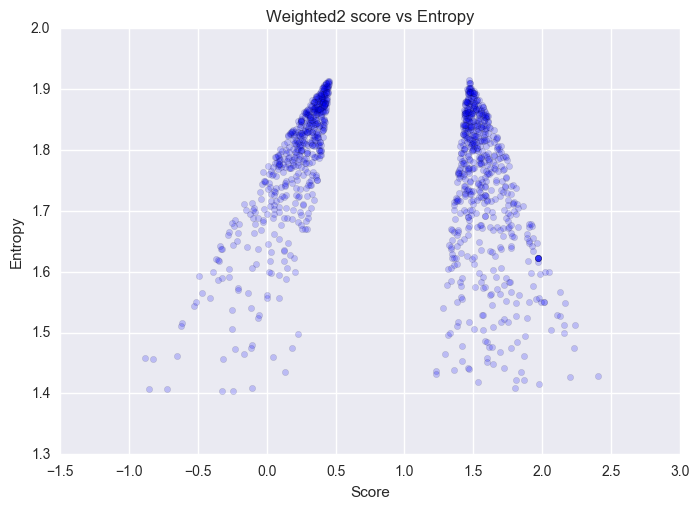

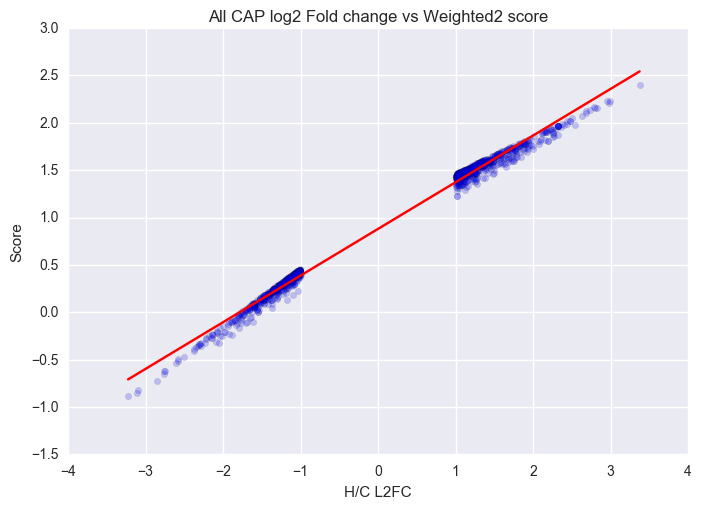

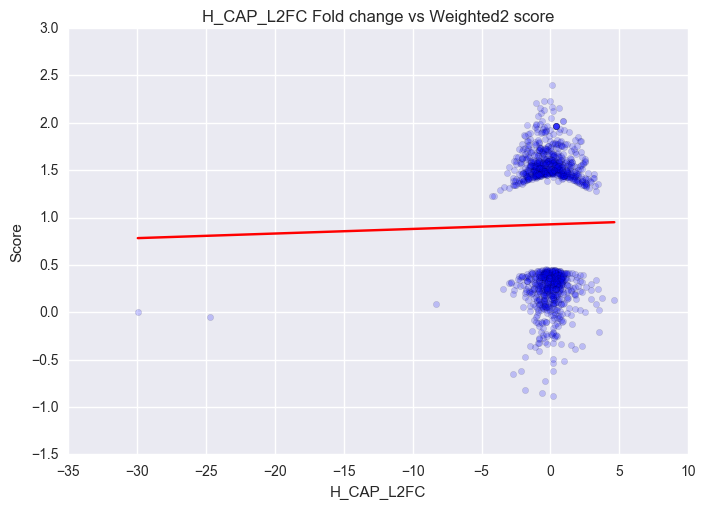

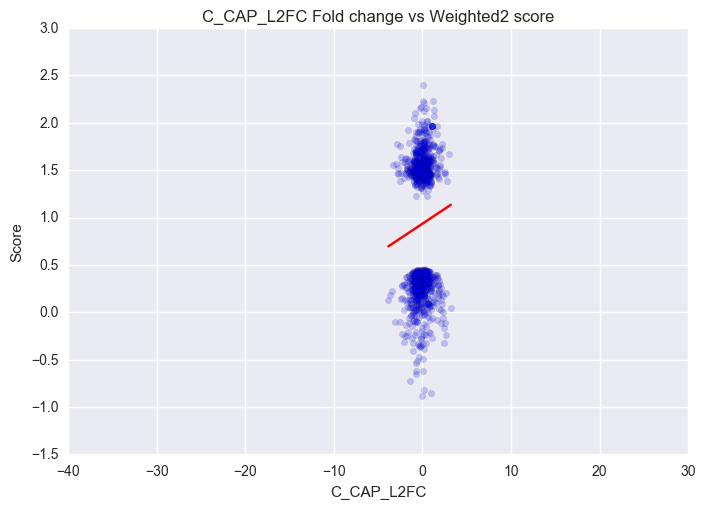

In [78]:
######  USABLE DATA, NOT OUTLIERS
### WEIGHTED2 = 0.5*ALL_L2FC + 0.5*ENTROPY

c = list(uc1)
w = uc1
w = w[c[3:5]] * 0.5
uc1['Weighted2'] = w.sum(axis=1)

# Weighted distribution
plt.hist(uc1['Weighted2'], bins=300)
plt.title("Weighted2 distribution")
plt.xlabel("Score")
plt.ylabel("# of genes")
plt.show()

print()
# plot weighted vs entropy
plt.scatter(uc1['Weighted2'], uc1['Entropy'], alpha=0.2)
plt.title("Weighted2 score vs Entropy")
plt.xlabel("Score")
plt.ylabel("Entropy")
plt.show()

print()
# plot all FC against score as scatter
x = uc1['all_L2FC']
y = uc1['Weighted2']
plt.scatter(uc1['all_L2FC'], uc1['Weighted2'], alpha=0.2)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='r')
plt.title("All CAP log2 Fold change vs Weighted2 score")
plt.xlabel("H/C L2FC")
plt.ylabel("Score")
plt.show()

print()
# plot H_FC against score as scatter
x = uc1['H_CAP_L2FC']
y = uc1['Weighted2']
plt.scatter(uc1['H_CAP_L2FC'], uc1['Weighted2'], alpha=0.2)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='r')
plt.title("H_CAP_L2FC Fold change vs Weighted2 score")
plt.xlabel("H_CAP_L2FC")
plt.ylabel("Score")
plt.show()

print()
# plot C_FC against score as scatter
x = uc1['C_CAP_L2FC']
y = uc1['Weighted2']
plt.scatter(uc1['C_CAP_L2FC'], uc1['Weighted2'], alpha=0.2)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='r')
plt.title("C_CAP_L2FC Fold change vs Weighted2 score")
plt.xlim(-40, 30)
plt.xlabel("C_CAP_L2FC")
plt.ylabel("Score")
plt.show()

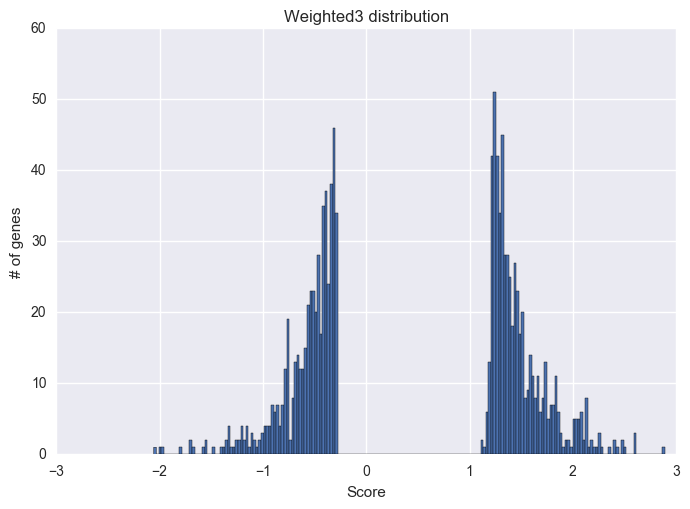

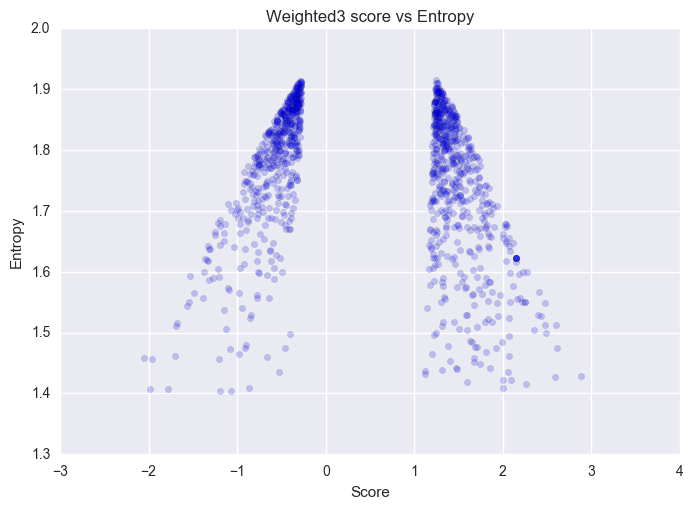

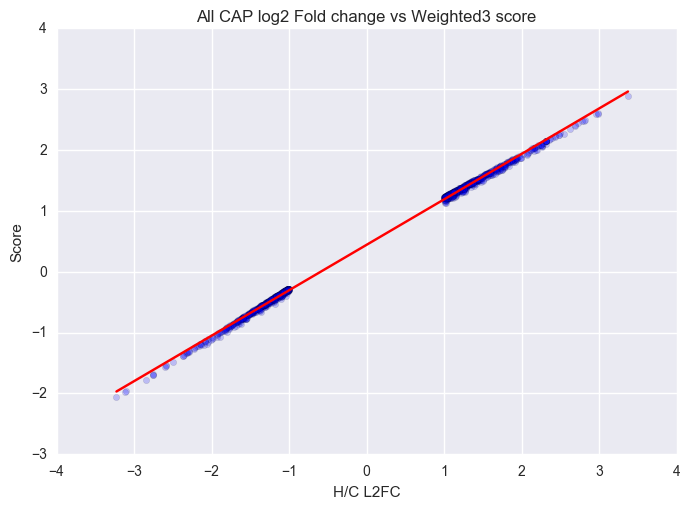

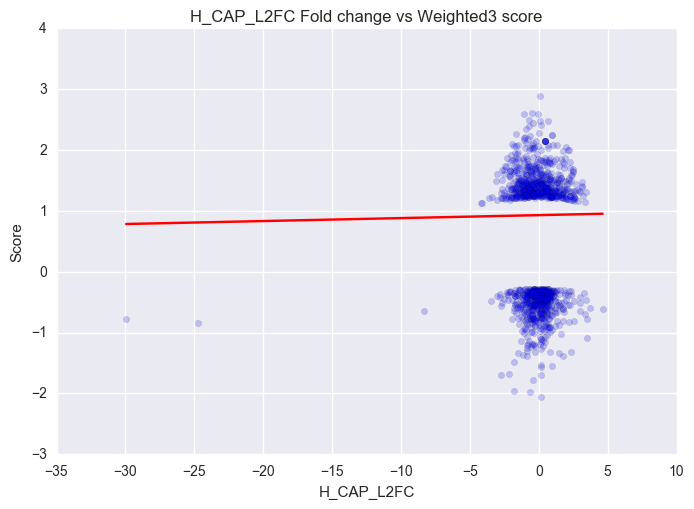

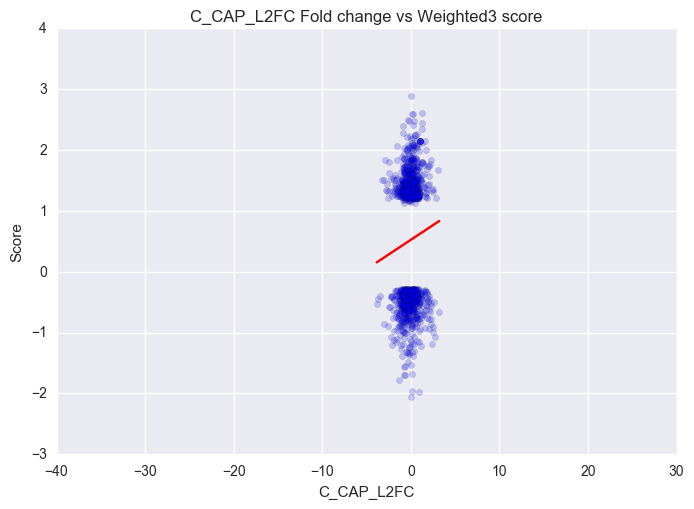

In [79]:
######  USABLE DATA, NOT OUTLIERS
### WEIGHTED3 = 0.75*ALL_L2FC + 0.25*ENTROPY

c = list(uc1)
uc1['Weighted3'] = uc1['all_L2FC']*0.75 + uc1['Entropy']*0.25

# Weighted distribution
plt.hist(uc1['Weighted3'], bins=200)
plt.title("Weighted3 distribution")
plt.xlabel("Score")
plt.ylabel("# of genes")
plt.show()

print()
# plot weighted vs entropy
plt.scatter(uc1['Weighted3'], uc1['Entropy'], alpha=0.2)
plt.title("Weighted3 score vs Entropy")
plt.xlabel("Score")
plt.ylabel("Entropy")
plt.show()

print()
# plot all FC against score as scatter
x = uc1['all_L2FC']
y = uc1['Weighted3']
plt.scatter(uc1['all_L2FC'], uc1['Weighted3'], alpha=0.2)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='r')
plt.title("All CAP log2 Fold change vs Weighted3 score")
plt.xlabel("H/C L2FC")
plt.ylabel("Score")
plt.show()

print()
# plot H_FC against score as scatter
x = uc1['H_CAP_L2FC']
y = uc1['Weighted2']
plt.scatter(uc1['H_CAP_L2FC'], uc1['Weighted3'], alpha=0.2)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='r')
plt.title("H_CAP_L2FC Fold change vs Weighted3 score")
plt.xlabel("H_CAP_L2FC")
plt.ylabel("Score")
plt.show()

print()
# plot C_FC against score as scatter
x = uc1['C_CAP_L2FC']
y = uc1['Weighted3']
plt.scatter(uc1['C_CAP_L2FC'], uc1['Weighted3'], alpha=0.2)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='r')
plt.title("C_CAP_L2FC Fold change vs Weighted3 score")
plt.xlim(-40, 30)
plt.xlabel("C_CAP_L2FC")
plt.ylabel("Score")
plt.show()